## Runge-Kutta Methods(RK4) 

### Only one ODE

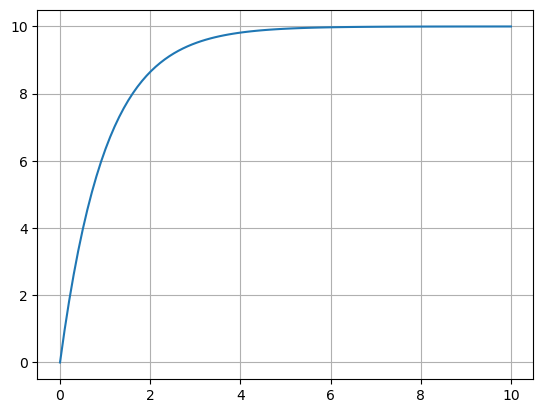

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def odeRK4(f,xinit,tinit,tfinal,n):
    h = (tfinal-tinit)/(n-1)
    x = np.zeros(n)
    t = np.linspace(tinit,tfinal,n)
    x[0] = xinit; t[0] = tinit
    for i in range(n-1):
        k1 = h*f(x[i],t[i])
        k2 = h*f(x[i]+(k1)/2,t[i]+h/2)
        k3 = h*f(x[i]+(k2)/2,t[i]+h/2)
        k4 = h*f(x[i]+k3,t[i])
        x[i+1] = x[i] + (k1+2*k2+2*k3+k4)/6
    return x,t
# Free fall of a particle experiencing air drag: dv/dt = a-bv
def F(v,t):
    return a - b*v

a = 10.0; b = 1.0
v,t = odeRK4(F,0,0,10,100)
plt.plot(t,v)
plt.grid()

plt.show()

### System of ODEs

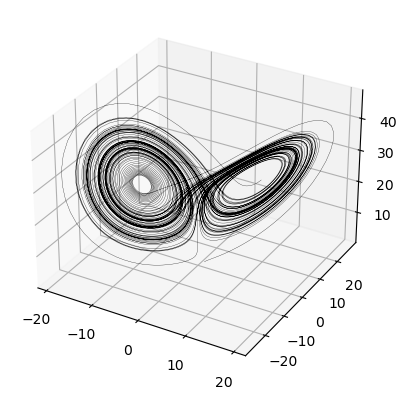

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits import mplot3d


def odeSystemRK4(f,xinit,tinit,tfinal,nt):
    nx = len(xinit)
    h = (tfinal-tinit)/(nt-1)
    x = np.zeros((nx,nt))
    t = np.linspace(tinit,tfinal,nt)
    x[:,0] = xinit; t[0] = tinit
    for i in range(nt-1):
        k1 = h*f(x[:,i],t[i])
        k2 = h*f(x[:,i]+(k1)/2,t[i]+h/2)
        k3 = h*f(x[:,i]+(k2)/2,t[i]+h/2)
        k4 = h*f(x[:,i]+k3,t[i]+h)
        x[:,i+1] = x[:,i] + (k1+2*k2+2*k3+k4)/6
    return x,t

def L(x,t):
    return np.array([sigma*(x[1] - x[0]), x[0]*(rho - x[2]) - x[1], x[0]*x[1] - beta*x[2]])

rho = 28;sigma = 10;beta = 8/3
xinit = np.array([1,1,1])
x,t = odeSystemRK4(L,xinit,0,100,10000)
plt.close()
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(x[0,:],x[1,:],x[2,:],color = 'black',linewidth = 0.2)
plt.show()

### Mark Newman Ex. 8.10: Cometary Orbits around the sun using Adaptive RK4 method
Governing equation:
$$\frac{d^2\vec{r}}{dt^2} = -GM\frac{\vec r}{r^3}$$
In the plane of motion $(z = 0)$:
$$\frac{d^2x}{dt^2} = -GM\frac{x}{r^3},\quad \frac{d^2y}{dt^2} = -GM\frac{y}{r^3}$$
Converting into system of first order differential equations:
$$\frac{dx}{dt} = v_x,\quad \frac{dy}{dt} = v_y$$
$$\frac{dv_x}{dt} = -GM\frac{x}{r^3},\quad \frac{dv_y}{dt} = -GM\frac{y}{r^3}$$

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Constants
G = 6.6743e-11    # Gravitational constant in m^3/(kg*(s^2))
M = 1.9891e30     # Mass of sun in kg
# Parameters/Initial Conditions
tinityrs = 0.0; tfinalyrs = 50.0    # Initial and final time in years
xinit = 4.0e12; yinit = 0.0    # Initial position in m
vxinit = 0.0; vyinit = 1000.0    # Initial velocities in m/s

# Initial vector of variables for System of DEs
rinit = np.array([xinit,yinit,vxinit,vyinit])

# Returns an array [dx/dt,dy/dt,dvx/dt,dvy/dt] for solving the System of DEs
# r is an array [x,y,vx,vy] for System of DEs
def f(r,t):
    x = r[0]; y = r[1]; vx = r[2]; vy = r[3]
    rmod = np.sqrt(x**2 + y**2)
    xdot = vx; ydot = vy
    vxdot = -G*M*x/(rmod**3)
    vydot = -G*M*y/(rmod**3)
    return np.array([xdot,ydot,vxdot,vydot])

#### 1. Fixed step size RK4

Time taken by fixed step RK4 method =  0:00:00.884215


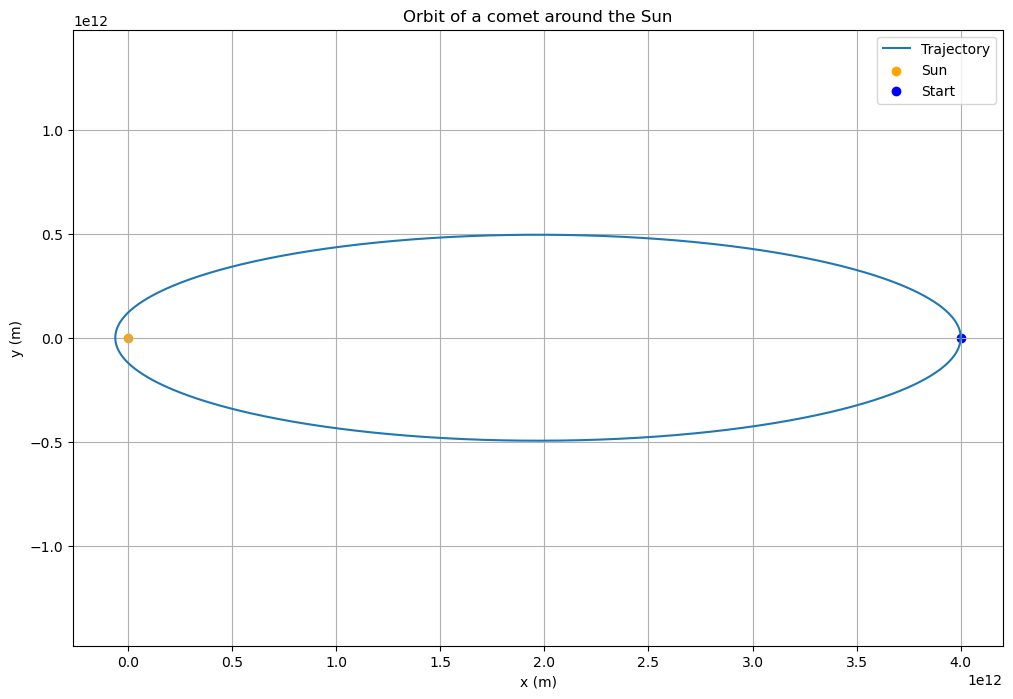

In [5]:
hdays = 2.0    # Time step size in days
hsec = hdays*24*3600    # Time step size in seconds

def odeRK4(f,rinit,tinit,tfinal,h):
    t = np.arange(tinit,tfinal+h,h)
    nr = len(rinit); nt = len(t)
    r = np.zeros((nt,nr))
    r[0] = rinit
    for i in range(nt-1):
        k1 = h*f(r[i],t[i])
        k2 = h*f(r[i]+0.5*k1,t[i]+0.5*h)
        k3 = h*f(r[i]+0.5*k2,t[i]+0.5*h)
        k4 = h*f(r[i]+k3,t[i]+h)
        r[i+1] = r[i] + ((k1+2*k2+2*k3+k4)/6)
        
    return r,t

tinitsec = tinityrs*365*24*3600
tfinalsec = tfinalyrs*365*24*3600
t1 = datetime.now()
r,t = odeRK4(f,rinit,tinitsec,tfinalsec,hsec)
t1 = datetime.now() - t1
# Extract the x,y positions
x = r[:,0]; y = r[:,1]

print('Time taken by fixed step RK4 method = ',t1)
# Plot
plt.figure(figsize=(12, 8))
plt.plot(x, y,label="Trajectory")
plt.scatter([0], [0], color='orange', label="Sun")
plt.scatter([xinit], [yinit], color='blue', label="Start")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.axis("equal")
plt.grid()
plt.legend()
plt.title("Orbit of a comet around the Sun")
plt.show()

#### 2. Adaptive step size RK4

Time taken by adaptive step RK4 method =  0:00:00.419714


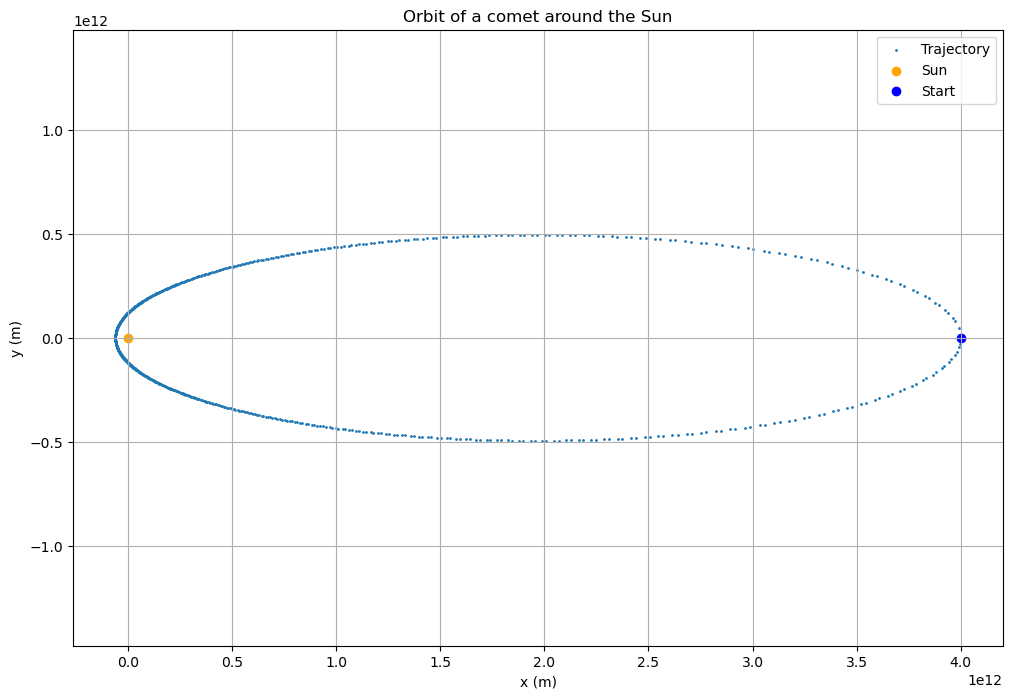

In [6]:
def doRK4Step(f,r,t,h):
    k1 = h*f(r,t)
    k2 = h*f(r+0.5*k1,t+0.5*h)
    k3 = h*f(r+0.5*k2,t+0.5*h)
    k4 = h*f(r+k3,t+h)
    rtplush = r+(k1+2*k2+2*k3+k4)/6
    return rtplush

# Desired error per unit time
delta_km_per_year = 1.0
delta = delta_km_per_year*1000/(365*24*3600)    # in m/sec

# r is used to perform intermediate calculations
r = rinit.copy()
t = tinitsec
# rvals will contain [x,y,vx,vy] for different time values contained in tvals
rvals = r.copy()
tvals = np.array([tinitsec])
# Initial stepsize
h = 2*30.0*24*3600

t2 = datetime.now()
while t <= tfinalsec:
    # Do 2 RK4 steps of size h to obtain r(t+2h) (more accurate)
    rstep1 = doRK4Step(f,r,t,h)
    rstep2 = doRK4Step(f,rstep1,t+h,h)
    
    # Do a single RK4 step of size 2h to obtain r(t+2h)
    rdoublestep = doRK4Step(f,r,t,2*h)
    
    # Estimate error in any desired quantity(here in distance) for this step 
    x1 = rstep2[0]; y1 = rstep2[1]
    x2 = rdoublestep[0]; y2 = rdoublestep[1]
    xerror = abs(x1-x2)/30; yerror = abs(y1-y2)/30
    rerror = np.sqrt(xerror**2+yerror**2)
    
    # Find the ratio of the desired error per step with estimated error per step
    rho = h*delta/rerror
    
    # If estimated error is better(smaller), then move to next step and update the step size to bigger value
    # If estimated error is worse(bigger), then re-run the step with updated smaller stepsize
    if rho >= 1:
        t += h
        r = rstep2
        rvals = np.vstack((rvals,r))
        tvals = np.append(tvals,t)
        h = h*(rho**0.25)
    elif rho < 1:
        h = h*(rho**0.25)
        
t2 = datetime.now() - t2
print('Time taken by adaptive step RK4 method = ',t2)

xvals = rvals[:,0]; yvals = rvals[:,1]

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(xvals, yvals,s = 1,label="Trajectory")
plt.scatter([0], [0], color='orange', label="Sun")
plt.scatter([xinit], [yinit], color='blue', label="Start")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.axis("equal")
plt.grid()
plt.legend()
plt.title("Orbit of a comet around the Sun")
plt.show()

In [7]:
print('In this case adaptive method was faster by',np.round(t2/t1*100.0,2),'%')

In this case adaptive method was faster by 47.47 %


### Non Linear Pendulum :
$\frac{d^2\theta}{dt^2} = -\frac{g}{l}\sin \theta$

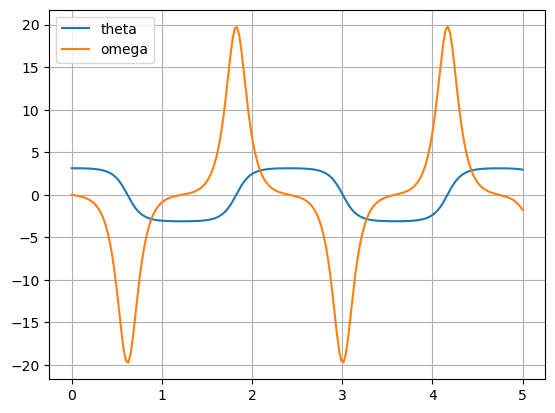

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def f(r,t):
    theta = r[0]; omega = r[1]
    ftheta = omega; fomega = -(g/l)*np.sin(theta)
    return np.array([ftheta,fomega])

def odeRK4(f,rinit,tinit,tfinal,nt):
    nr = len(rinit)
    h = (tfinal - tinit)/(nt-1)
    r = np.zeros((nt,nr))
    t = np.linspace(tinit,tfinal,nt)
    r[0,:] = rinit
    for i in range(nt-1):
        k1 = h*f(r[i,:],t[i])
        k2 = h*f(r[i,:] + k1/2,t[i] + h/2)
        k3 = h*f(r[i,:] + k2/2,t[i] + h/2)
        k4 = h*f(r[i,:] + k3,t[i] + h)
        r[i+1,:] = r[i,:] + (k1 + 2*k2 + 2*k3 + k4)/6
    return r,t

g = 980 ## in cm/sec
l = 10  ## in cm
thetainit = 179  ## in degrees
omegainit = 0  ## in rad/sec
tinit = 0
tfinal = 5

thetainitrad = np.pi*thetainit/180  ## convert angle to radians
rinit = np.array([thetainitrad,omegainit])
r,t = odeRK4(f,rinit,tinit,tfinal,200)
theta = r[:,0]; omega = r[:,1]
plt.plot(t,theta,label = 'theta')
plt.plot(t,omega,label = 'omega')
plt.grid();plt.legend()
plt.show()

#### Animation of pendulum

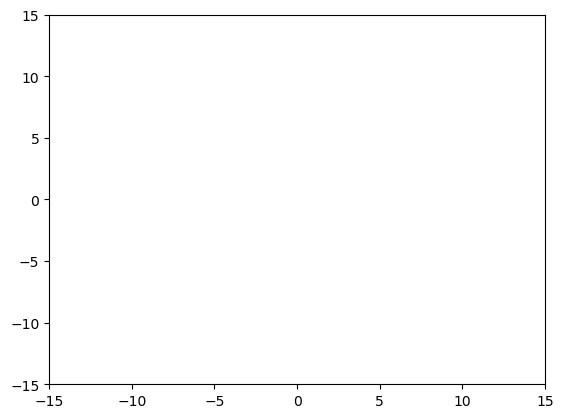

In [9]:
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = plt.axes(xlim = (-15,15),ylim = (-15,15))
arm, = ax.plot([],[],color = 'black')
bob, = ax.plot([],[],'o')

def update(frame):
    theta_current = theta[frame]
    x_current = l*np.sin(theta_curent)
    y_current = -l*np.cos(theta_curent)
    arm.set_data([0,x_current],[0,y_current])
    bob.set_data([x_current],[y_current])
    return arm,bob

anim = FuncAnimation(fig = fig, func = update, frames = len(t), interval = 20)
plt.show()

## Leap Frog Method(RK2)

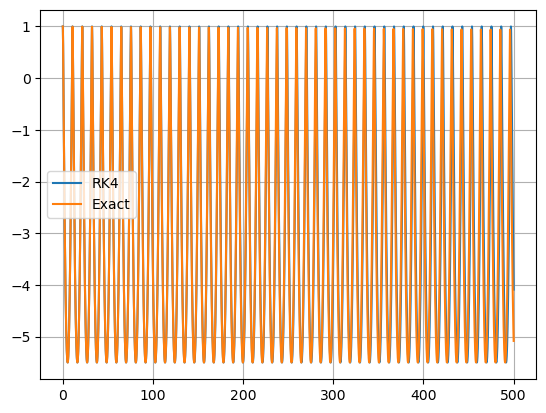

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def odeRK4(f,rinit,tinit,tfinal,h):
    t = np.arange(tinit,tfinal+h,h)
    nr = len(rinit); nt = len(t)
    r = np.zeros((nt,nr))
    r[0] = rinit
    for i in range(nt-1):
        k1 = h*f(r[i],t[i])
        k2 = h*f(r[i]+0.5*k1,t[i]+0.5*h)
        k3 = h*f(r[i]+0.5*k2,t[i]+0.5*h)
        k4 = h*f(r[i]+k3,t[i]+h)
        r[i+1] = r[i] + ((k1+2*k2+2*k3+k4)/6)
        
    return r,t

def odeLF(f,rinit,tinit,tfinal,h):
    t = np.arange(tinit,tfinal+h,h)
    nr = len(rinit); nt = len(t)
    r = np.zeros((nt,nr))
    r[0,:] = rinit
    r_half = rinit + (h/2)*f(rinit,tinit)
    t_half = tinit + (h/2)
    for i in range(nt-1):
        r[i+1,:] = r[i,:] + h*f(r_half,t_half)
        r_half += h*f(r[i+1,:],t[i+1])
        t_half += h/2
    return r,t

def f(r,t):
    x = r[0]; v = r[1]
    xdot = v
    vdot = v**2 - x - 5
    return np.array([xdot, vdot],float)

tinit = 0; tfinal = 500; h = 0.01
rinit = np.array([1,0])

r,t = odeLF(f,rinit,tinit,tfinal,h)
r1 = odeint(f,rinit,t)
r2,t = odeRK4(f,rinit,tinit,tfinal,h)

x = r[:,0]; x1 = r1[:,0]; x2 = r2[:,0]

#plt.plot(t,x,label = 'Leap Frog')
plt.plot(t,x2,label = 'RK4')
#plt.plot(tvals,x3,label = 'Adaptive RK4')
plt.plot(t,x1,label = 'Exact')
plt.grid();plt.legend()
plt.show()

## Orbit of Earth(using Verlet method)

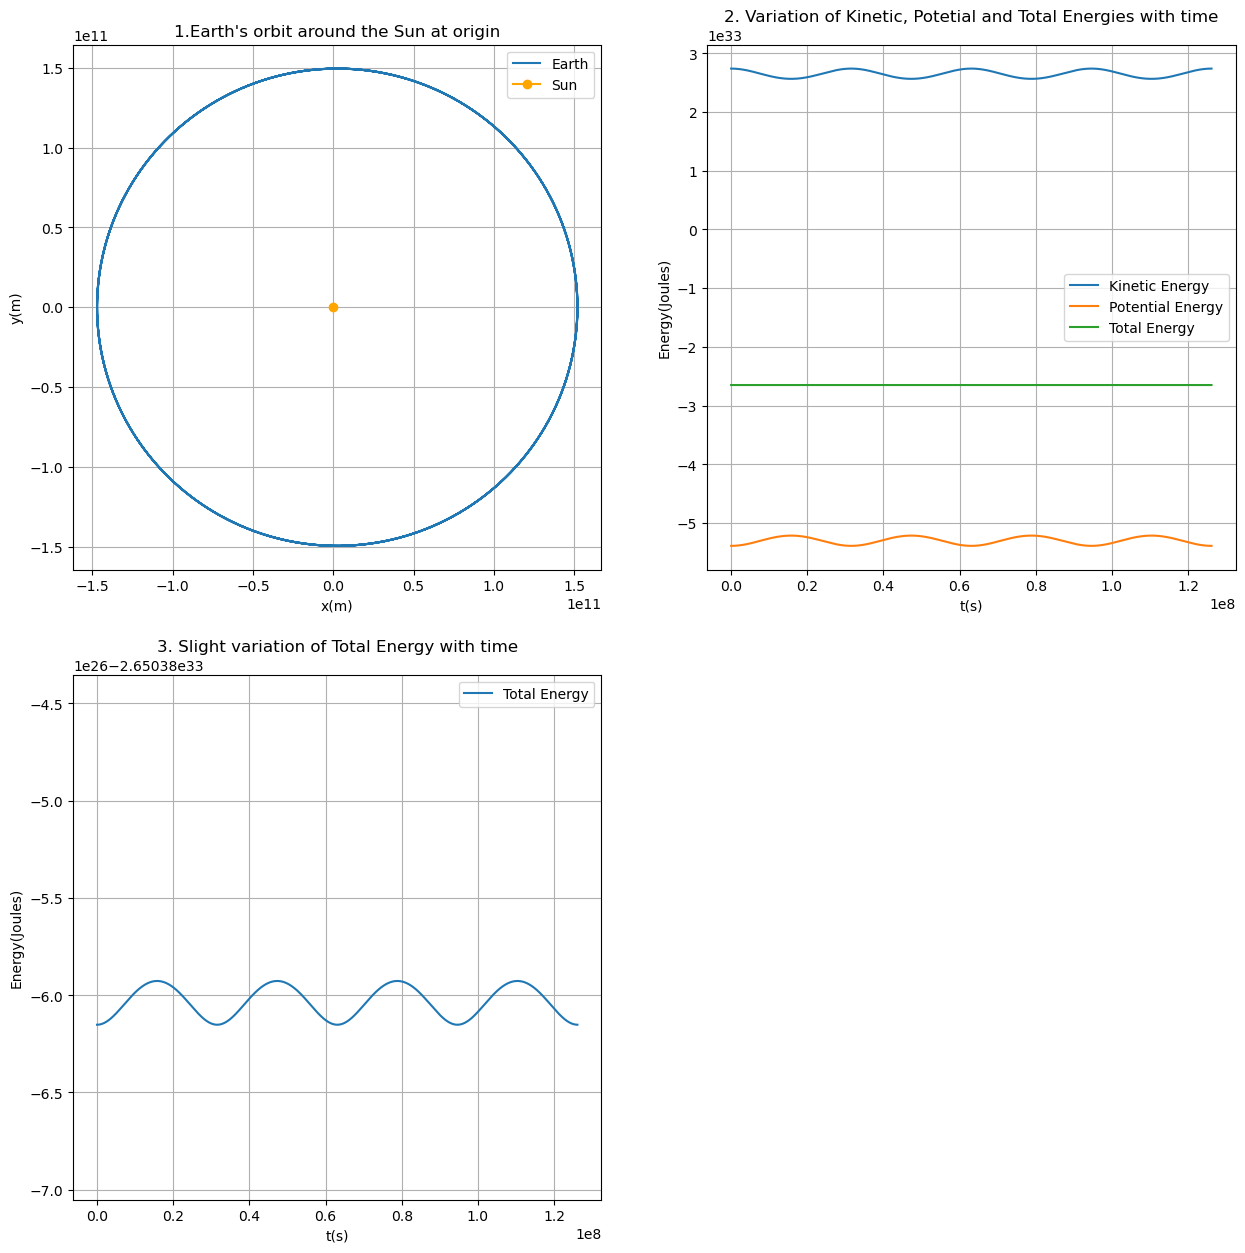

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def odeVerlet(f,rinit,vinit,tinit,tfinal,h):
    t = np.arange(tinit,tfinal+h,h)
    nt = len(t); nr = len(rinit)
    r = np.zeros((nt,nr))
    v = np.zeros((nt,nr))
    r[0,:] = rinit
    v[0,:] = vinit
    vhalf = vinit + (h/2)*f(rinit,tinit)
    for i in range(nt-1):
        r[i+1,:] = r[i,:] + h*vhalf
        k = h*f(r[i+1,:],t[i+1])
        v[i+1,:] = vhalf + k/2
        vhalf += k
    return t,r,v

def f(r,t):
    x = r[0]; y = r[1]
    rmod = np.sqrt(x**2+y**2)
    return -G*M*r/(rmod**3)

## Parameters
G = 6.6738E-11
M = 1.9891E30; m = 5.9722E24
rPerihilion = 1.4710E11
vPerihilion = 3.0287E4
## time in days
tinitDays = 0; tfinalDays = 4*365
## time step in hours
hHr = 1

## Convert time to seconds
tinitSec = tinitDays*24*60*60
tfinalSec = tfinalDays*24*60*60
hSec = hHr*60*60

rinit = np.array([-rPerihilion,0])
vinit = np.array([0,-vPerihilion])
t,r,v = odeVerlet(f,rinit,vinit,tinitSec,tfinalSec,hSec)
x = r[:,0]; y = r[:,1]
vx = v[:,0]; vy = v[:,1]
KE = 0.5*m*(vx**2 + vy**2)
PE = -G*M*m/np.sqrt(x**2 + y**2)
TE = KE + PE
TE0 = TE[0]
deltaTE = max(TE) - min(TE)

fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(2,2,1)
ax1.plot(x,y,label = 'Earth')
ax1.plot([0],[0],color='orange', marker='o',label = 'Sun')
ax1.set_xlabel('x(m)');ax1.set_ylabel('y(m)')
ax1.set_title("1.Earth's orbit around the Sun at origin")
ax1.grid();ax1.legend()

ax2 = fig.add_subplot(2,2,2)
ax2.plot(t,KE,label = 'Kinetic Energy')
ax2.plot(t,PE,label = 'Potential Energy')
ax2.plot(t,TE,label = 'Total Energy')
ax2.set_xlabel('t(s)');ax2.set_ylabel('Energy(Joules)')
ax2.set_title("2. Variation of Kinetic, Potetial and Total Energies with time")
ax2.grid();ax2.legend()

ax3 = fig.add_subplot(2,2,3)
ax3.plot(t,TE,label = 'Total Energy')
ax3.set_xlabel('t(s)');ax3.set_ylabel('Energy(Joules)')
ax3.set_title("3. Slight variation of Total Energy with time")
ax3.set_ylim((TE0-4*deltaTE,TE0+8*deltaTE))
ax3.grid();ax3.legend()

#plt.tight_layout()
plt.show()

## Boundary Value Problem(Using Shooting Method):

In [12]:
from numpy import array,arange

me = 9.1094e-31
hbar = 1.0546e-34
e = 1.6022e-19
xinit = 0.0
xfinal = 5.2918e-11
psiinit = 0.0
phiinit = 1.0
N = 1000; h = (xfinal-xinit)/N
rinit = array([psiinit,phiinit],float)

def V(x):
    return 0.0

def f(r,x,E):
    psi = r[0]; phi = r[1]
    fpsi = phi
    fphi = (2*me/hbar**2)*(V(x) - E)*psi
    return array([fpsi,fphi],float)

def psiFinal(E):
    r = rinit.copy()
    for xi in arange(xinit,xfinal,h):
        k1 = h*f(r,xi,E)
        k2 = h*f(r+0.5*k1,xi+0.5*h,E)
        k3 = h*f(r+0.5*k2,xi+0.5*h,E)
        k4 = h*f(r+k3,xi+h,E)
        r += (k1 + 2*k2 + 2*k3 + k4)/6
    return r[0]


E1 = 300*e
E2 = E1 + e

psi2 = psiFinal(E1)
Nmax = 30
tol = e/1000
for i in range(Nmax+1):
    psi1,psi2 = psi2,psiFinal(E2)
    dE = -psi2*(E2 - E1)/(psi2 - psi1)
    E1, E2 = E2, E2 + dE
    if abs(E2 - E1) <= tol:
        break
    ;

if i == Nmax:
    print('Diverged!')
else:
    print('E =',E2/e,'eV')


E = 3357.1592959394525 eV
